In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet
import yfinance as yf
import os
import csv

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'SOL'
yf_crypto = 'SOL'

# Set YF crypto symbol
symbol = f'{yf_crypto}-USD'

# Create crypto df
#crypto_df = f'{crypto}_df'.lower()

In [5]:
# Retreive max data
data = yf.Ticker(f'{symbol}')
history = data.history(period='max')

# Define file path and name
#filepath = f'~/crypto-forecast/resources/{crypto}-USD.csv'
#filepath = os.path.expanduser('~/crypto-forecast/resources/ADA-USD.csv')

# Create dataframe
crypto_df = pd.DataFrame(history)

# Set 'Date' as the index and parse dates
crypto_df.index = pd.to_datetime(crypto_df.index)

# Drop columns
crypto_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Drop last row
crypto_df = crypto_df.drop(crypto_df.tail(1).index)

# Drop rows with any NaN values
crypto_df.dropna(inplace=True)

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Drop timezone from datetime
crypto_df = crypto_df.reset_index()
crypto_df['Date'] = crypto_df['Date'].dt.tz_localize(None)
crypto_df.set_index('Date', inplace=True)

# Set file path to store data as a csv
csv_filepath = os.path.expanduser(f'~/crypto-forecast/resources/{crypto}-USD.csv')

# Write the DataFrame to a CSV file
crypto_df.to_csv(csv_filepath, index=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2020-04-10,0.832005,1.313487,0.694187,0.951054,87364276
2020-04-11,0.951054,1.049073,0.765020,0.776819,43862444
2020-04-12,0.785448,0.956670,0.762426,0.882507,38736897
2020-04-13,0.890760,0.891603,0.773976,0.777832,18211285
2020-04-14,0.777832,0.796472,0.628169,0.661925,16747614


,Open,High,Low,Close,Volume
Date,,,,,
2024-06-04,164.925064,171.816818,164.515533,171.801926,2057558426
2024-06-05,171.801926,175.475311,171.382996,173.482910,2405906612
2024-06-06,173.482910,174.304703,167.864212,170.016220,1965442993
2024-06-07,170.015839,172.438156,155.798767,162.507050,3298527575
2024-06-08,162.496750,163.620178,157.542953,157.968903,1722237785


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

157.96890258789062

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.998658,0.998239,0.997185,0.725733
High,0.998658,1.000000,0.997882,0.998902,0.741594
Low,0.998239,0.997882,1.000000,0.998401,0.711173
Close,0.997185,0.998902,0.998401,1.000000,0.730621
Volume,0.725733,0.741594,0.711173,0.730621,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2020-04-10,0.951054,87364276
2020-04-11,0.776819,43862444
2020-04-12,0.882507,38736897
2020-04-13,0.777832,18211285
2020-04-14,0.661925,16747614
...,...,...
2024-06-04,171.801926,2057558426
2024-06-05,173.482910,2405906612
2024-06-06,170.016220,1965442993


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate volatility
df_close_ma.loc[:, 'Percent Change'] = df_close_ma['Close'].pct_change()*100
df_close_ma.loc[:, 'Volatility'] = df_close_ma['Percent Change'].rolling(10).std(ddof=0) * np.sqrt(252)

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2020-05-29,0.579415,2066857,0.590875,0.607929,0.638247
2020-05-30,0.587933,2449095,0.591753,0.604491,0.630985
2020-05-31,0.570022,1892967,0.587863,0.599199,0.626849
2020-06-01,0.577495,2159877,0.581725,0.594586,0.620749
2020-06-02,0.564669,1295757,0.576889,0.590758,0.616485


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-06-04,171.801926,2057558426,166.869078,162.410636,154.407851
2024-06-05,173.482910,2405906612,167.882278,163.099987,155.151923
2024-06-06,170.016220,1965442993,167.884286,163.829383,155.914923
2024-06-07,162.507050,3298527575,167.269907,164.503127,156.323416
2024-06-08,157.968903,1722237785,166.259529,164.673759,156.629185


<Axes: xlabel='Date'>

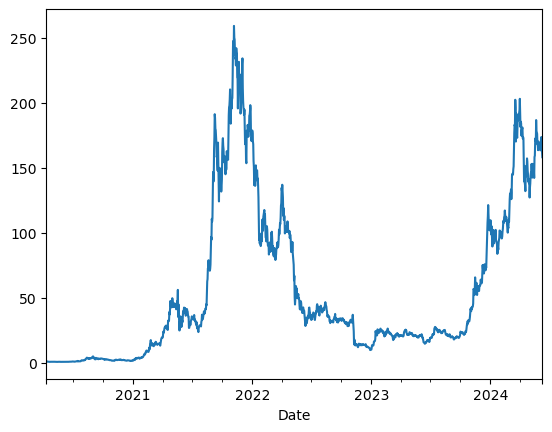

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2020-04-10,0.951054,87364276
1,2020-04-11,0.776819,43862444
2,2020-04-12,0.882507,38736897
3,2020-04-13,0.777832,18211285
4,2020-04-14,0.661925,16747614
...,...,...,...
1516,2024-06-04,171.801926,2057558426
1517,2024-06-05,173.482910,2405906612
1518,2024-06-06,170.016220,1965442993
1519,2024-06-07,162.507050,3298527575


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

17:00:01 - cmdstanpy - INFO - Chain [1] start processing
17:00:01 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
1606,2024-09-02
1607,2024-09-03
1608,2024-09-04
1609,2024-09-05
1610,2024-09-06


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1581,2024-08-08,205.821285,178.349490,218.297528,197.777662,215.474261,-6.676905,-6.676905,-6.676905,0.143687,0.143687,0.143687,-6.820592,-6.820592,-6.820592,0.0,0.0,0.0,199.144381
1582,2024-08-09,206.347964,178.024289,218.907082,197.956432,216.350499,-7.156616,-7.156616,-7.156616,-0.253440,-0.253440,-0.253440,-6.903177,-6.903177,-6.903177,0.0,0.0,0.0,199.191348
1583,2024-08-10,206.874643,179.906664,221.187236,198.232223,217.197148,-6.876997,-6.876997,-6.876997,0.082623,0.082623,0.082623,-6.959620,-6.959620,-6.959620,0.0,0.0,0.0,199.997646
1584,2024-08-11,207.401322,179.923330,222.082408,198.510088,217.979317,-6.730718,-6.730718,-6.730718,0.254836,0.254836,0.254836,-6.985555,-6.985555,-6.985555,0.0,0.0,0.0,200.670604
1585,2024-08-12,207.928001,181.438202,221.530636,198.864827,218.741078,-6.892707,-6.892707,-6.892707,0.084034,0.084034,0.084034,-6.976742,-6.976742,-6.976742,0.0,0.0,0.0,201.035294
1586,2024-08-13,208.454680,181.920237,221.793795,199.096571,219.491949,-7.379172,-7.379172,-7.379172,-0.449998,-0.449998,-0.449998,-6.929174,-6.929174,-6.929174,0.0,0.0,0.0,201.075508
1587,2024-08-14,208.981359,180.305085,223.898845,199.228228,220.424031,-6.700928,-6.700928,-6.700928,0.138257,0.138257,0.138257,-6.839185,-6.839185,-6.839185,0.0,0.0,0.0,202.280431
1588,2024-08-15,209.508038,182.789127,223.990672,199.207422,221.100613,-6.559860,-6.559860,-6.559860,0.143687,0.143687,0.143687,-6.703547,-6.703547,-6.703547,0.0,0.0,0.0,202.948178
1589,2024-08-16,210.034717,180.026554,223.321826,199.431257,221.942421,-6.773022,-6.773022,-6.773022,-0.253440,-0.253440,-0.253440,-6.519582,-6.519582,-6.519582,0.0,0.0,0.0,203.261695
1590,2024-08-17,210.561396,182.533436,224.012811,199.654590,222.717953,-6.202627,-6.202627,-6.202627,0.082623,0.082623,0.082623,-6.285249,-6.285249,-6.285249,0.0,0.0,0.0,204.358769


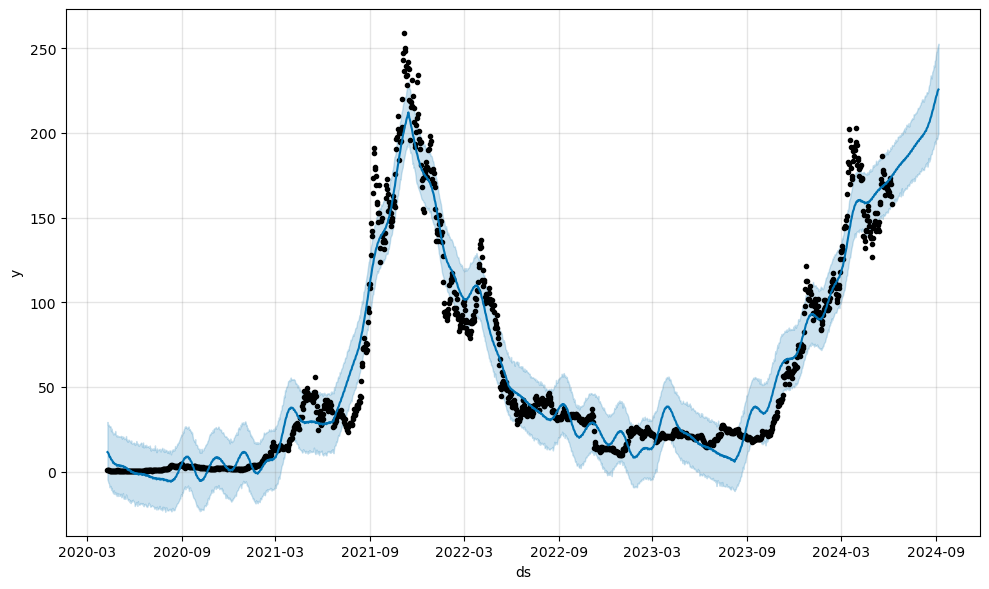

In [20]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-06-09,175.195525,157.662697,192.755959
2024-06-10,175.470112,157.567919,192.540802
2024-06-11,175.384391,157.421822,192.386790
2024-06-12,176.422147,159.213838,193.635645
2024-06-13,176.876578,160.851946,194.680222
...,...,...,...
2024-09-02,221.761908,196.875936,247.790678
2024-09-03,222.341817,196.119625,248.004677
2024-09-04,223.996355,196.605487,250.043468


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

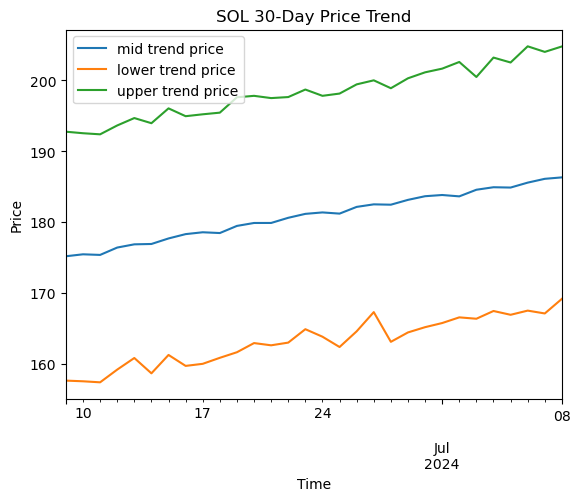

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

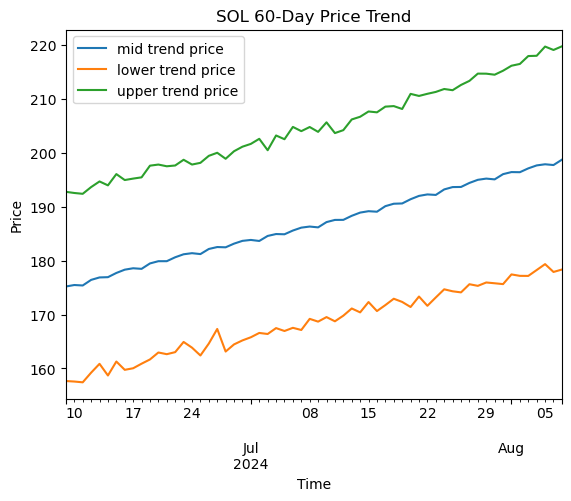

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

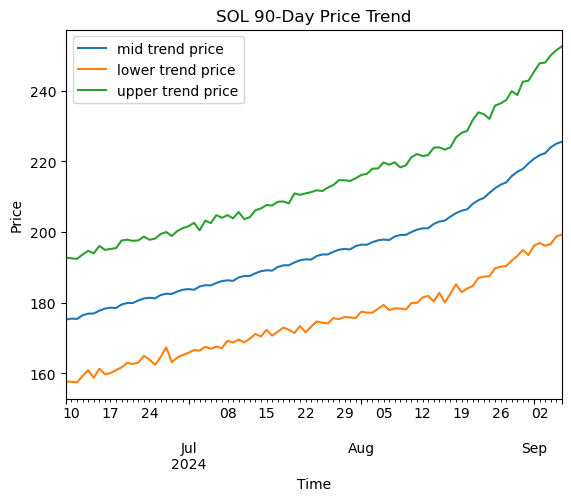

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

157.96890258789062

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

175.19552479293648

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

166.58221369041354

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

175.2010461659741

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

186.20891466088142

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

198.81603197713426

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

225.71590124664874

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

0.118

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

0.194

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

0.355

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

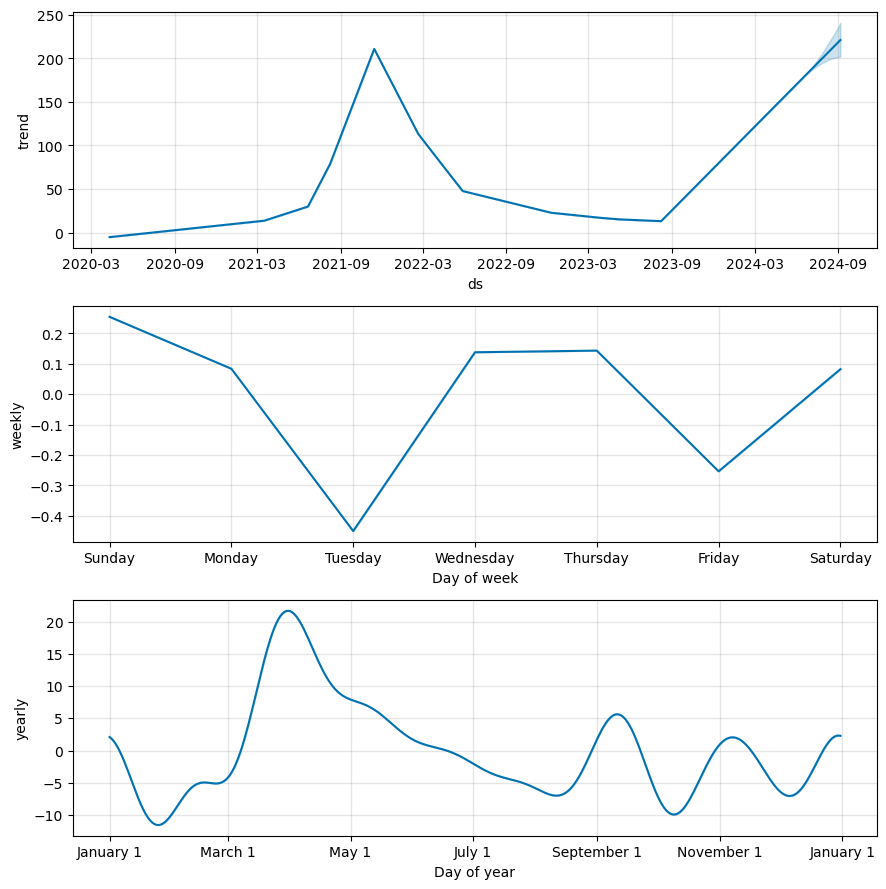

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

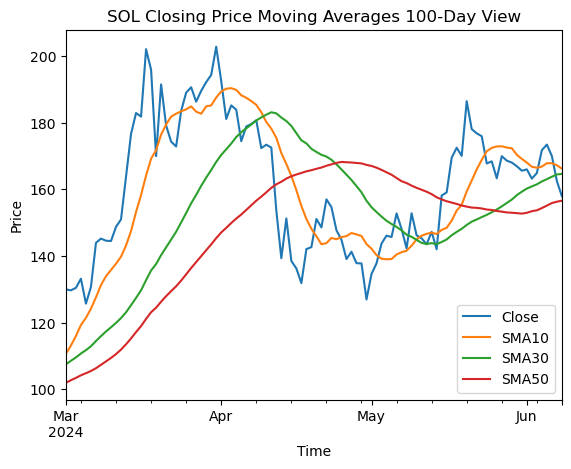

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

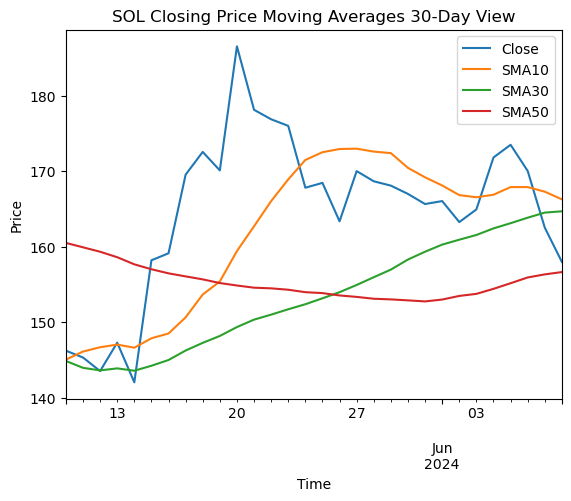

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View') 
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-06-09
File created :  2024-06-09.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.43657100200653076,-0.07364667494769794,-0.0009456964793739253,0.3544596118546628
ADA,0.43657100200653076,-0.08437373181845453,0.002834181787628731,0.36173019111251126
ADA,0.43657100200653076,-0.08372637062435029,0.0025919668069758206,0.3631142967037635
ADA,0.43657100200653076,-0.0783190338427533,0.004381382002310641,0.36321329122708335
ATOM,7.759523868560791,-0.2525451407294217,-0.22995154564524733,0.08676291965413196
AVAX,32.29003143310547,-0.06238204683353343,0.016250905637703372,0.184324988794629
AVAX,32.29003143310547,-0.061383912293528464,0.006255814491331391,0.188757389641659
BNB,682.6651611328125,-0.25945675235825627,-0.21619087415535265,-0.19462572272913758
BONK,2.700000004551839e-05,0.19694570130627698,0.3277996886564134,0.4415377509818921
BTC,69305.7734375,-0.1351637782567381,-0.09261706566887273,-0.09372540555309616
DOGE,0.14605900645256042,-0.18446710000937716,-0.08920949588743987,-0.03966410323402325
ETH,3680.949951171875,-0.11161221692021561,-0.03134563847923688,-0.